# Data analysis and figures for PTSD project
* FYI: need to filter the mice bc right now the els data is also included in the big datafile -- DONE
* 8/21 refactoring according to the sleep repo, also creating figures for NCE to be submitted in Aug, 2023


In [ ]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 451, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 451 (delta 113), reused 145 (delta 54), pack-reused 242
Receiving objects: 100% (451/451), 3.25 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (239/239), done.
/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.11-py3-none-any.whl size=1012 sha256=64c59745f5663601d9f8f95c3187796bdfa9850fe24eebd88e9bcdcc6f72f997
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_za3_2w/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [ ]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns

from sleep.src import core

sns.set_context('paper', font_scale=0.8)
import pandas as pd
from datetime import date
%matplotlib inline

### Input/output

In [ ]:
dr = core.GoogleDrive()
gdrive  = dr.mount_drive()

save_dir = '/gdrive/Shareddrives/Turi_lab/Data/PTSD_project/!analysis/saveFolder/R21_NCE_08_2023'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### loading data

In [ ]:
data = dr.load_spreadsheet_data('all_cohorts_freezing_FINAL')
data.replace('NA', np.NaN, inplace=True)
data[['freezing']] = data[['freezing']].apply(pd.to_numeric)
data[['date']] = data[['date']].apply(pd.to_datetime)
data = data[(data['els']=='n') &
            (data['psilocybin']=='n')]
data['cohort_id'] = data['cohort']+'_'+data['id']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 1 to 1828
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           1240 non-null   float64       
 1   genotype           1245 non-null   object        
 2   id                 1245 non-null   object        
 3   day                1245 non-null   object        
 4   condition          1245 non-null   object        
 5   sex                1245 non-null   object        
 6   cohort             1245 non-null   object        
 7   exposure_mins      1240 non-null   object        
 8   analyzed_duration  1240 non-null   object        
 9   date               1176 non-null   datetime64[ns]
 10  time               1176 non-null   object        
 11  els                1245 non-null   object        
 12  psilocybin         1245 non-null   object        
 13  cohort_id          1245 non-null   object        
dtypes: datet

loading DOB-s

In [ ]:
age_data = dr.load_spreadsheet_data('id_dob')
age_data['cohort_id']= age_data['cohort']+'_'+age_data['id']
age_data.drop(['id', 'cohort'], axis=1, inplace=True )
age_data['dob'] = age_data['dob'].astype('datetime64[ns]')
age_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 1 to 214
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dob        214 non-null    datetime64[ns]
 1   cohort_id  214 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 3.5+ KB


In [ ]:
# merging freezing w/ DOBs
merged_df = data.merge(age_data,left_on='cohort_id',
                       right_on='cohort_id')
print(merged_df.dtypes)
print(f'merged_df shape {merged_df.shape}')
merged_df.head()

######################
# saving data to csv #
######################

# merged_df.to_csv(join(save_dir, f"all_cohorts_data_{date.today()}.csv"))

freezing                    float64
genotype                     object
id                           object
day                          object
condition                    object
sex                          object
cohort                       object
exposure_mins                object
analyzed_duration            object
date                 datetime64[ns]
time                         object
els                          object
psilocybin                   object
cohort_id                    object
dob                  datetime64[ns]
dtype: object
merged_df shape (1125, 15)


,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob
0,3.51,2aFlox_het,5HT2Afl05a-5,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11
1,8.94,2aFlox_het,5HT2Afl05a-5,seflb,control,male,ptsd1,3.5,3.5,2021-04-04,9:52 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11
2,43.10,2aFlox_het,5HT2Afl05a-5,recall1,control,male,ptsd1,0,5,2021-04-05,9:35 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11
3,22.61,2aFlox_het,5HT2Afl05a-5,recall2,control,male,ptsd1,5,5,2021-04-07,10:36 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11
4,37.22,2aFlox_het,5HT2Afl05a-5,recall3,control,male,ptsd1,5,5,2021-04-09,10:17 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11


In [ ]:
print('all mice: {}\n'.format(merged_df['cohort_id'].nunique()))
print(merged_df.groupby('sex')['cohort_id'].nunique())

all mice: 149

sex
female    56
male      93
Name: cohort_id, dtype: int64


working on age at the SEFLA

In [ ]:
df = merged_df[merged_df["day"] == "sefla"]

df['age_at_SEFLA'] = (df.loc[:,('date')] - df.loc[:,('dob')]).dt.days/7
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   freezing           149 non-null    float64       
 1   genotype           149 non-null    object        
 2   id                 149 non-null    object        
 3   day                149 non-null    object        
 4   condition          149 non-null    object        
 5   sex                149 non-null    object        
 6   cohort             149 non-null    object        
 7   exposure_mins      149 non-null    object        
 8   analyzed_duration  149 non-null    object        
 9   date               149 non-null    datetime64[ns]
 10  time               149 non-null    object        
 11  els                149 non-null    object        
 12  psilocybin         149 non-null    object        
 13  cohort_id          149 non-null    object        
 14  dob       

<ipython-input-8-a1b8d95f66d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_at_SEFLA'] = (df.loc[:,('date')] - df.loc[:,('dob')]).dt.days/7


In [ ]:
df_age = df[['cohort_id', 'age_at_SEFLA']]
df_age.set_index(['cohort_id'], inplace=True)
# saving
# df_age.to_csv(join(save_dir, f'age_at_sefla_{date.today()}.csv'))

In [ ]:
result = merged_df.join(df_age, how='outer')
result

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob,age_at_SEFLA
0,3.51,2aFlox_het,5HT2Afl05a-5,sefla,control,male,ptsd1,60,60,2021-04-03,1:34 PM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11,NaN
1,8.94,2aFlox_het,5HT2Afl05a-5,seflb,control,male,ptsd1,3.5,3.5,2021-04-04,9:52 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11,NaN
2,43.10,2aFlox_het,5HT2Afl05a-5,recall1,control,male,ptsd1,0,5,2021-04-05,9:35 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11,NaN
3,22.61,2aFlox_het,5HT2Afl05a-5,recall2,control,male,ptsd1,5,5,2021-04-07,10:36 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11,NaN
4,37.22,2aFlox_het,5HT2Afl05a-5,recall3,control,male,ptsd1,5,5,2021-04-09,10:17 AM,n,n,ptsd1_5HT2Afl05a-5,2020-12-11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ptsd9_30-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,13.0
ptsd9_30-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,13.0
ptsd9_31-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,13.0
ptsd9_31-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,13.0


<ipython-input-11-31692cdb1e93>:21: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  d3 = sns.catplot(data=df, y='condition', x="age_at_SEFLA", legend=True,
<ipython-input-11-31692cdb1e93>:21: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  d3 = sns.catplot(data=df, y='condition', x="age_at_SEFLA", legend=True,


Text(0.5, 1.0, 'Males and Females (N=149)')

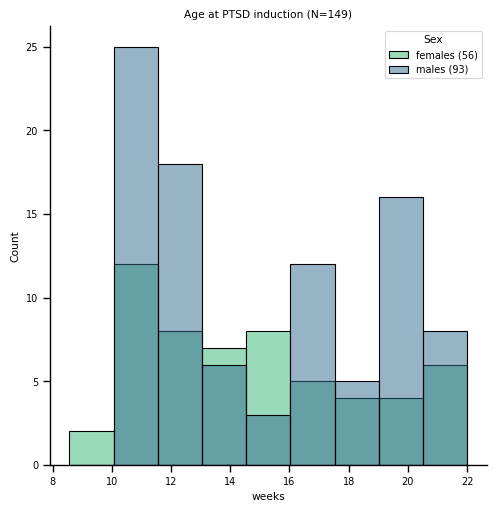

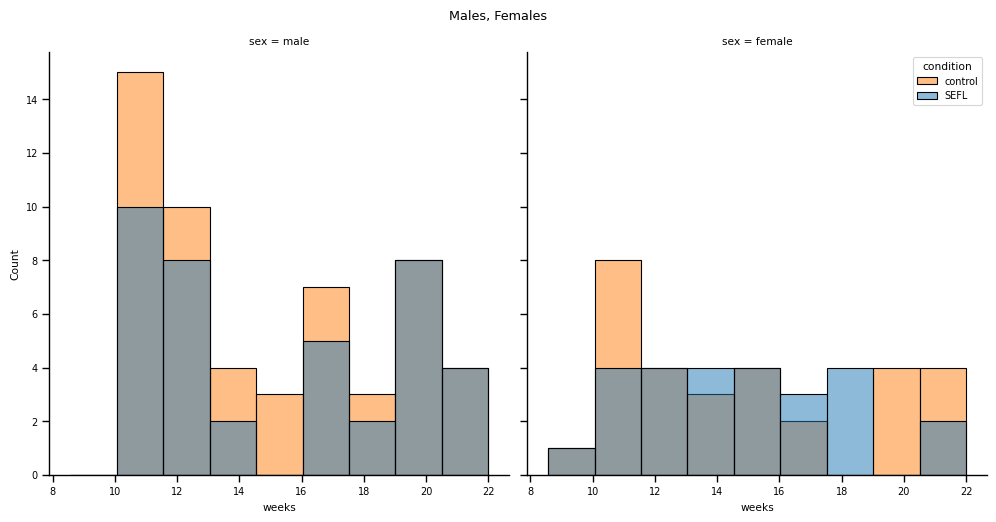

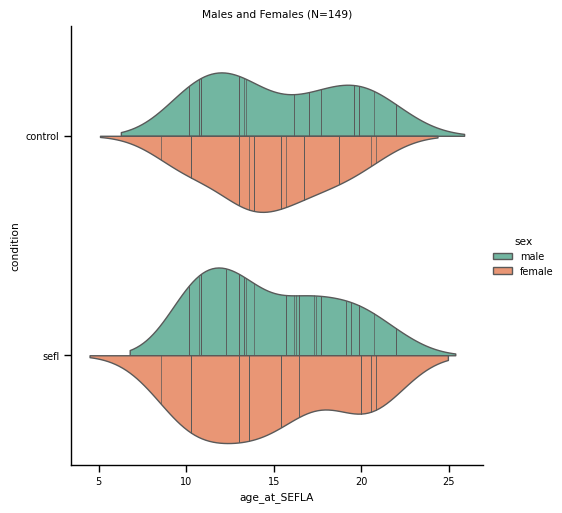

In [ ]:
# plot1
num_sexes = df.groupby(['sex'])['cohort_id'].nunique()
num_mice = df.cohort_id.nunique()

d = sns.displot(df, x='age_at_SEFLA', hue='sex', palette="viridis",
                legend=False)
plt.title('Age at PTSD induction (N=%s)' %num_mice,) #fontsize=18
d.set_xlabels('weeks') #fontsize=20
# d.set_ylabels(fontsize=20)
plt.legend(title='Sex', loc='upper right', labels=['females (%s)' % num_sexes[0],
                                                   'males (%s)' % num_sexes[1]])

# plot2
d2 = sns.displot(df, x="age_at_SEFLA", col="sex", hue="condition",
                 legend=False)
d2.set_xlabels('weeks') #fontsize=20
d2.fig.suptitle("Males, Females", y=1.03) #, fontsize=20
plt.legend(title='condition', loc='upper right', labels=['control','SEFL'])

# plot3
d3 = sns.catplot(data=df, y='condition', x="age_at_SEFLA", legend=True,
                 orient='h', hue='sex', kind='violin', inner='stick',
                 split=True, palette='Set2',
                 scale='count', scale_hue=False)
plt.title(f'Males and Females (N={df.cohort_id.nunique()})',
          ) #fontsize=20

# plt.savefig(join(save_dir, 'noELS', f'sex_distrib_violin_{date.today()}.png'),
#             transparent=True, dpi=300, figsize=(5,5), bbox_inches='tight')
# d.savefig(join(save_dir, 'noELS',f'SEFL_age_at_PTSD_all_{date.today()}.png'),
#           transparent=True, dpi=300, figsize=(5,5), bbox_inches='tight')
# d2.savefig(join(save_dir, 'noELS',f'SEFL_age_at_PTSD_sexes_{date.today()}.png'),
#            transparent=True, dpi=300, figsize=(5,10), bbox_inches='tight')


# TODO: controlling the titles of the hue'ed plots

In [ ]:
# cohorts included
print(f'cohorts: {merged_df.cohort.unique()}\n')
print(f'number of mice: {merged_df.cohort_id.nunique()}\n')
print(merged_df.groupby(['sex'])['cohort_id'].nunique())

cohorts: ['ptsd1' 'ptsd2' 'ptsd3' 'ptsd4' 'ptsd5' 'ptsd6' 'ptsd7' 'ptsd8' 'ptsd9'
 'ptsd10' 'els1' 'els2' 'ptsd12' 'ptsd14']

number of mice: 149

sex
female    56
male      93
Name: cohort_id, dtype: int64


### Plotting stuff

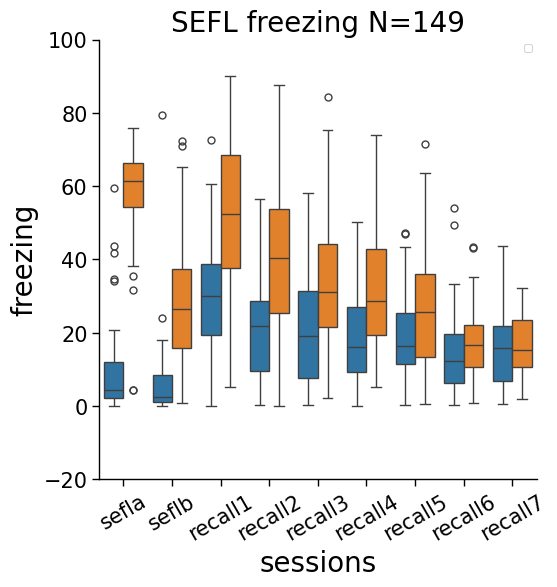

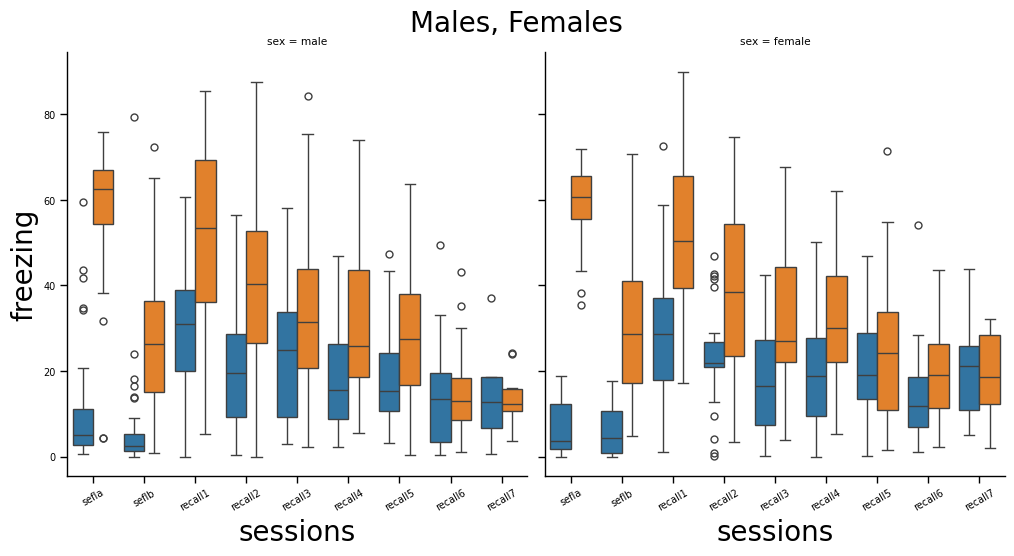

In [ ]:
# plot1
df = merged_df

g = sns.catplot(data = df, kind='box',
                x="day", y="freezing", hue="condition", legend=False)

plt.title(f'SEFL freezing N={df.cohort_id.nunique()}',
          fontsize=20)
plt.legend(loc='upper right')
g.set_xticklabels(rotation=30, fontsize=15)
g.set_xlabels('sessions', fontsize=20)
g.set_ylabels(fontsize=20)
g.set_yticklabels(fontsize=15)

# plot2
g2 = sns.catplot(data= df, kind='box',
                x='day', y='freezing', hue='condition',
                 col='sex', legend=False)
g2.set_xticklabels(rotation = 30)
g2.set_ylabels(fontsize=20)
g2.fig.suptitle("Males, Females", y=1.03, fontsize=20)
g2.set_xlabels('sessions', fontsize=20)

# g.savefig(join(save_dir, f'SEFL_freezing_at_PTSD_all_boxplot_{date.today()}.png'),
#           transparent=True, dpi=300)
# g2.savefig(join(save_dir, f'SEFL_freezing_at_PTSD_sexes_boxplot_{date.today()}.png'),
#            transparent=True, dpi=300)

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


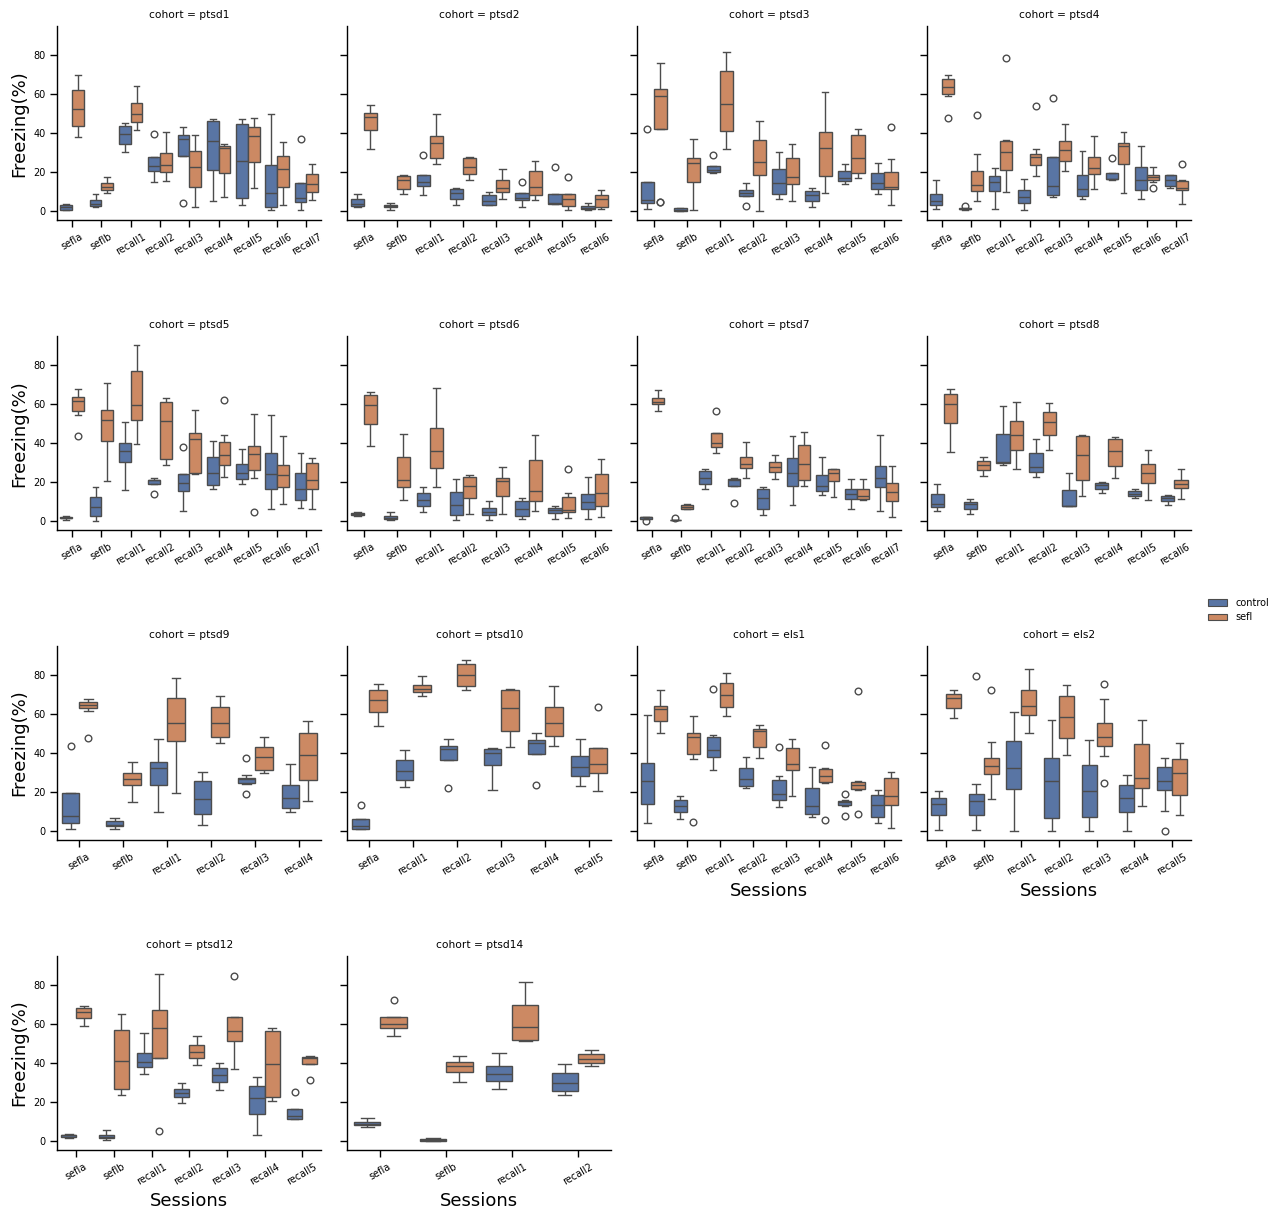

In [ ]:
g = sns.FacetGrid(merged_df, col="cohort", col_wrap=4,
                  sharey=True, sharex=False
                  )
g.map(sns.boxplot, "day", "freezing", "condition",
      hue_order=["control", "sefl"], palette="deep"
      )
g.set_xticklabels(rotation = 30)
g.add_legend()
g.figure.subplots_adjust(hspace=.35)
g.set_axis_labels("Sessions", "Freezing(%)")
g.set_xlabels(fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.subplots_adjust(hspace=0.6, wspace=.1)
# g.savefig(join(save_dir, 'noELS',
#                f'ALL_cohorts_ SEFL_frezing_per_cohort_boxplot_grid{date.today()}.png'),
#           transparent=True, dpi=300, bbox_inches='tight')

Filtering out some cohorts

In [ ]:
# ptsd1, ptsd7 -> sleep
# ptsd8, ptsd10, ptsd12 -> sert hets
# ptsd11 -> pattern sep
# FYI ptsd9 has data only up to recall4
# ptsd13 -> psilocybin administration after seflb
# els1, els2 -> els mice

cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6', 'ptsd9']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5']
filtered_freezing = merged_df[(merged_df['cohort'].isin(cohort_list)) &
                              (merged_df['day'].isin(day_list))]

# exporting data to CSV
filtered_freezing.to_csv(join(save_dir, f'filtered_nonELS_mice_{date.today()}.csv'))

In [ ]:
filtered_freezing.head()

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob
72,5.03,wt,81,sefla,control,male,ptsd2,60,60,2021-04-28,11:59 AM,n,n,ptsd2_81,2021-02-16
73,0.45,wt,81,seflb,control,male,ptsd2,3.5,3.5,2021-04-29,4:40 PM,n,n,ptsd2_81,2021-02-16
74,8.28,wt,81,recall1,control,male,ptsd2,5,5,2021-04-30,1:37 PM,n,n,ptsd2_81,2021-02-16
75,7.12,wt,81,recall2,control,male,ptsd2,5,5,2021-05-03,10:17 AM,n,n,ptsd2_81,2021-02-16
76,7.57,wt,81,recall3,control,male,ptsd2,5,5,2021-05-05,10:04 AM,n,n,ptsd2_81,2021-02-16


plotting stuff

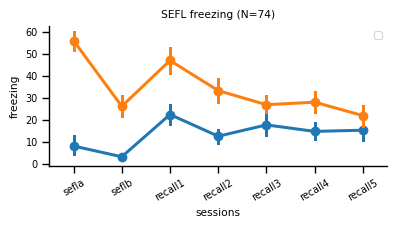

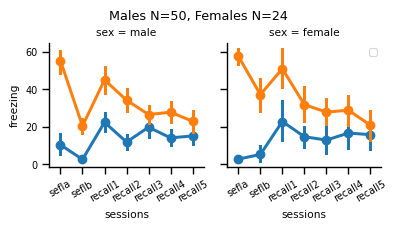

<Figure size 1920x1440 with 0 Axes>

In [ ]:
# df plot1

df = filtered_freezing

g = sns.catplot(data = df, kind='point',
               x="day", y="freezing", hue="condition", legend=False,
              height=2, aspect=2)
plt.title(f'SEFL freezing (N={df.cohort_id.nunique()})',
          )#fontsize=20
plt.legend(loc='upper right')
g.set_xticklabels(rotation=30)#, fontsize=15
g.set_xlabels('sessions', )#fontsize=20
g.set_ylabels()#fontsize=20
# g.set_yticklabels(fontsize=15)

# df plot2
num_sexes = df.groupby(['sex'])['cohort_id'].nunique()

g2 = sns.catplot(data= df, kind='point',
                x='day', y='freezing', hue='condition',
                 col='sex', legend=False, height=2)

plt.legend(loc='upper right')
g2.set_xticklabels(rotation = 30)#, fontsize=15
g2.set_xlabels('sessions', )#fontsize=20
g2.set_ylabels()#fontsize=20
# g.set_yticklabels(fontsize=15)

title = f'Males N={num_sexes[1]}, Females N={num_sexes[0]}'
g2.fig.suptitle(title, y=1.03, )#fontsize=20
plt.figure(dpi=300)

# saving
g.savefig(join(save_dir,
               f'SEFL_frezing_selected_cohorts_{date.today()}.png'),
          transparent=True, dpi=300, bbox_inches='tight')
g2.savefig(join(save_dir,
                'SEFL_frezing_selected_cohorts_males_females_{date.today()}.png'),
           transparent=True, dpi=300, bbox_inches='tight')

SEFL males vs. females

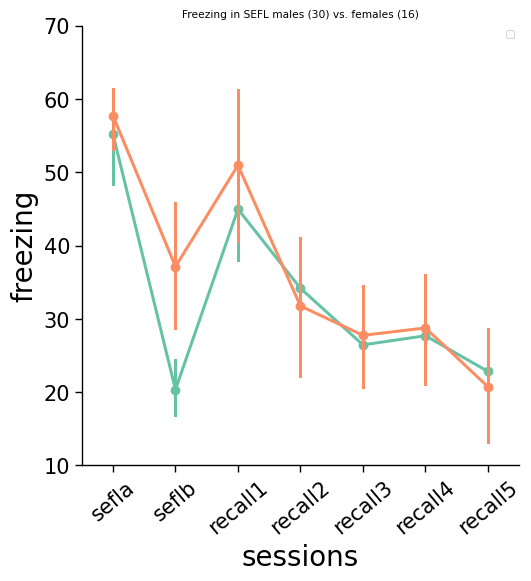

In [ ]:
sefl_sexes = filtered_freezing[filtered_freezing['condition'] == 'sefl']

s_females = sefl_sexes.groupby('sex')['cohort_id'].nunique()[0]
s_males = sefl_sexes.groupby('sex')['cohort_id'].nunique()[1]

g = sns.catplot(data = sefl_sexes, kind='point',
               x="day", y="freezing", hue="sex", legend=False,
               palette='Set2')
plt.title(f'Freezing in SEFL males ({s_males}) vs. females ({s_females})')
plt.legend(loc='upper right')
g.set_xticklabels(rotation=40, fontsize=15)
g.set_xlabels('sessions', fontsize=20)
g.set_ylabels(fontsize=20)
g.set_yticklabels(fontsize=15)

# g.savefig(join(save_dir, 'noELS',
#                        f'Freezing_SEFL_males_vs_females_pointplot{date.today()}.png'),
#           transparent=True, dpi=300, bbox_inches='tight')

Control group mice

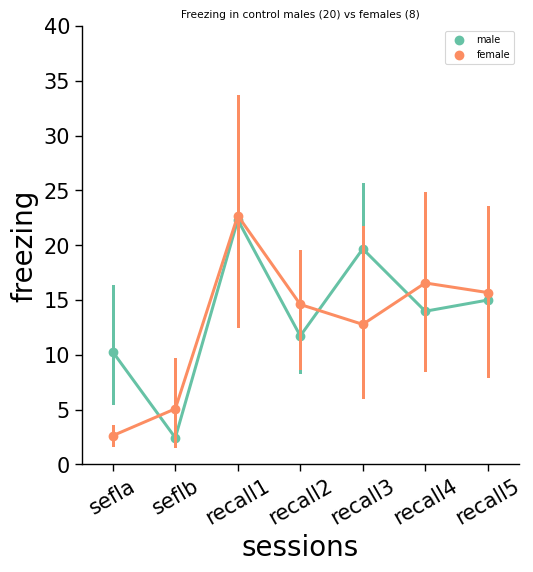

In [ ]:
ctrl_sexes = filtered_freezing[filtered_freezing['condition'] == 'control']

c_females = ctrl_sexes.groupby('sex')['cohort_id'].nunique()[0]
c_males = ctrl_sexes.groupby('sex')['cohort_id'].nunique()[1]

g = sns.catplot(data = ctrl_sexes, kind='point',
               x="day", y="freezing", hue="sex", legend=False,
               palette='Set2')
plt.title(f'Freezing in control males ({c_males}) vs females ({c_females})')
plt.legend(loc='upper right')
g.set_xticklabels(rotation=30, fontsize=15)
g.set_xlabels('sessions', fontsize=20)
g.set_ylabels(fontsize=20)
g.set_yticklabels(fontsize=15)

# g.savefig(join(save_dir, 'noELS',
#                        f'Freezing_CONTROL_males_vs_females_pointplot_{date.today()}.png'),
#           transparent=True, dpi=300, bbox_inches='tight')

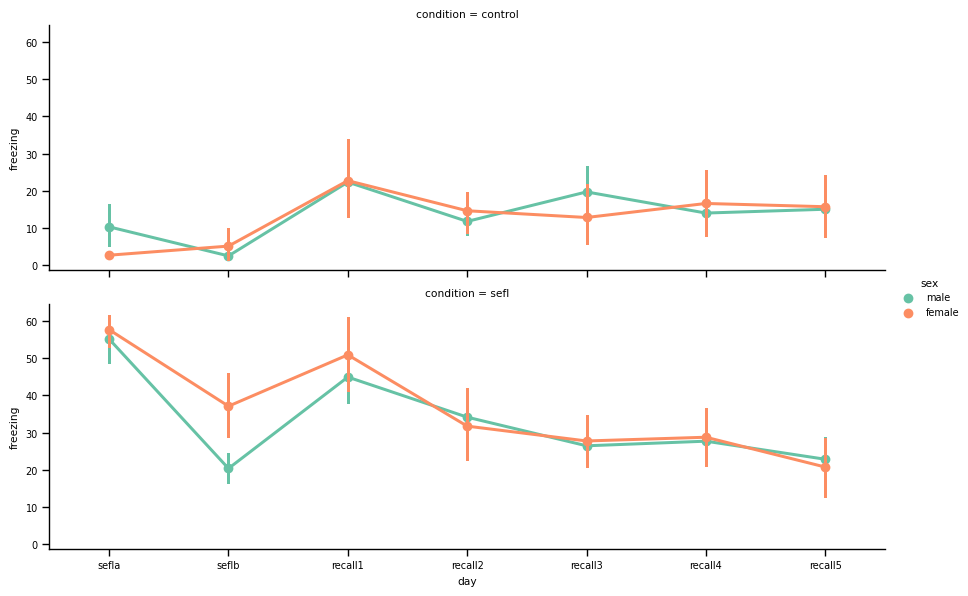

In [ ]:
chart = sns.catplot(
    data=filtered_freezing[filtered_freezing['condition'].isin(['sefl', 'control'])],
    x='day',
    y='freezing',
    kind='point',
    hue='sex',
    palette='Set2',
    row='condition',
    aspect=3,
    height=3
)
# chart.savefig(join(save_dir, 'noELS',
#                        f'Freezing_control_sefl_males_females_pointplot_{date.today()}.png'),
#           transparent=True, dpi=300, bbox_inches='tight')

### from here on it's mostly exploratory

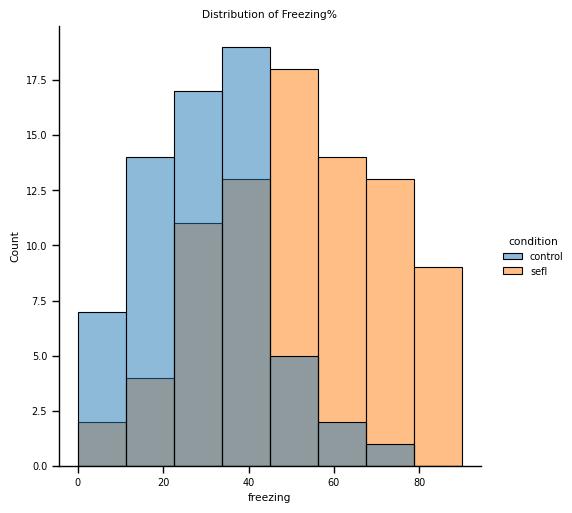

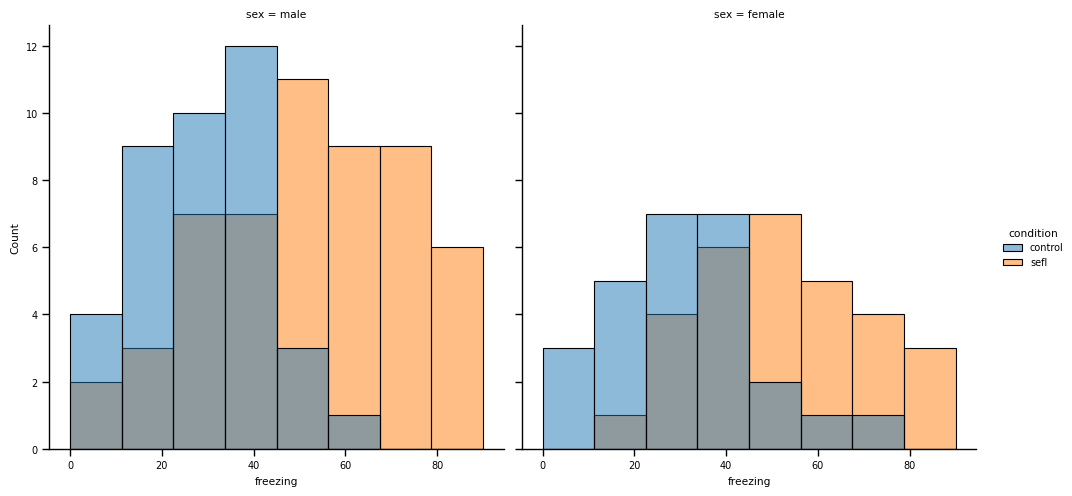

In [ ]:
df = merged_df[merged_df["day"] == "recall1"]
# control = df[df["condition"] == "control"]
# sefl = df[df["condition"] == "SEFL"]
d = sns.displot(df, x="freezing", hue="condition", bins=8)
d.set(title='Distribution of Freezing%')
d2 = sns.displot(df, x="freezing", col="sex", hue="condition", bins=8)

# saving figures
# d.savefig(os.path.join(save_path+'Freezing_distributions_all_recall1.png'),
#           transparent=True, dpi=300)
# d2.savefig(os.path.join(save_path+'freezing_dsitribution_sexes_recall1.png'),
#            transparent=True, dpi=300)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'sefla'),
  Text(1, 0, 'seflb'),
  Text(2, 0, 'recall1'),
  Text(3, 0, 'recall2'),
  Text(4, 0, 'recall3'),
  Text(5, 0, 'recall4'),
  Text(6, 0, 'recall5')])

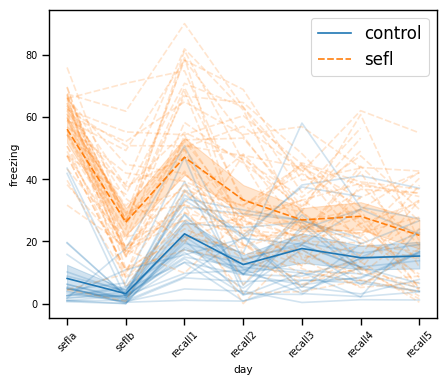

In [ ]:
f, ax = plt.subplots(figsize=(5,4))
g = sns.lineplot(data=filtered_freezing, x='day', y='freezing', hue='condition',
                 units='cohort_id', estimator=None, style='condition', alpha=.2,
                 ax=ax)
g = sns.lineplot(data=filtered_freezing, x='day', y='freezing', hue='condition',
                 style='condition', legend=False, ax=ax)
plt.legend(fontsize=12)
plt.xticks(rotation=45)


# plt.savefig(os.path.join(save_path, "freezing_mean_across_days.png"),
#           transparent=True, dpi=300)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'sefla'),
  Text(1, 0, 'seflb'),
  Text(2, 0, 'recall1'),
  Text(3, 0, 'recall2'),
  Text(4, 0, 'recall3'),
  Text(5, 0, 'recall4'),
  Text(6, 0, 'recall5')])

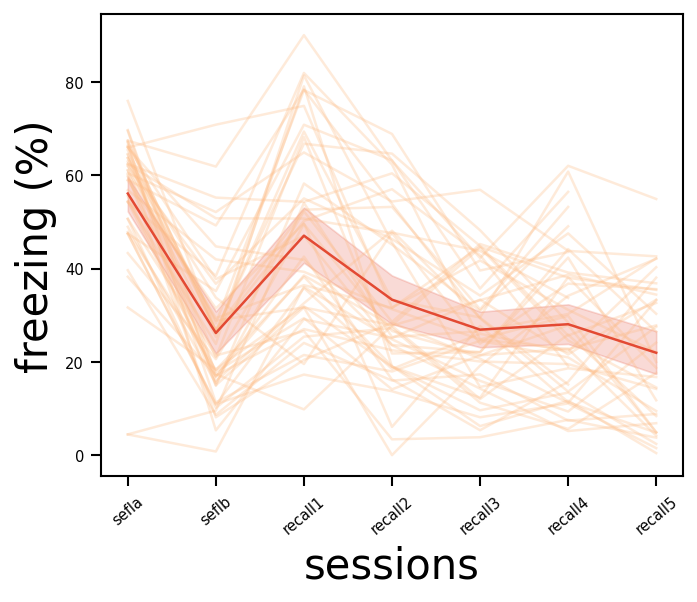

In [ ]:
f, ax = plt.subplots(figsize=(5,4),dpi=150)
g = sns.lineplot(data=filtered_freezing[filtered_freezing['condition']=='sefl'],
                 x='day', y='freezing', estimator=None, alpha=.3,units='cohort_id',
                 ax=ax, color='#fdbb84')
g = sns.lineplot(data=filtered_freezing[filtered_freezing['condition']=='sefl'],
                 x='day', y='freezing',
                 ax=ax, color='#e34a33')
ax.set_ylabel('freezing (%)',fontsize=20)
ax.set_xlabel('sessions', fontsize=20)
plt.xticks(rotation=40)

# plt.savefig(join(save_dir, 'sefl_freezing.png'),
#           transparent=True, dpi=300)
# plt.legend(fontsize=20)

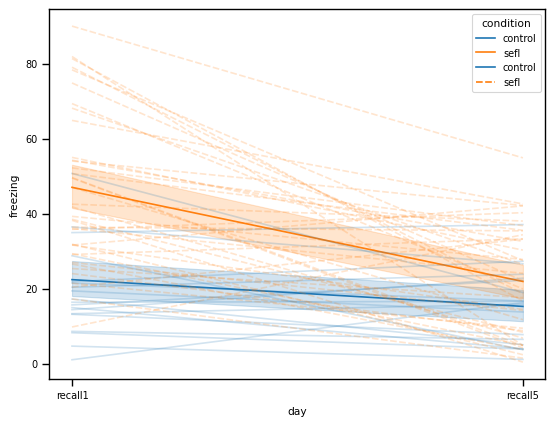

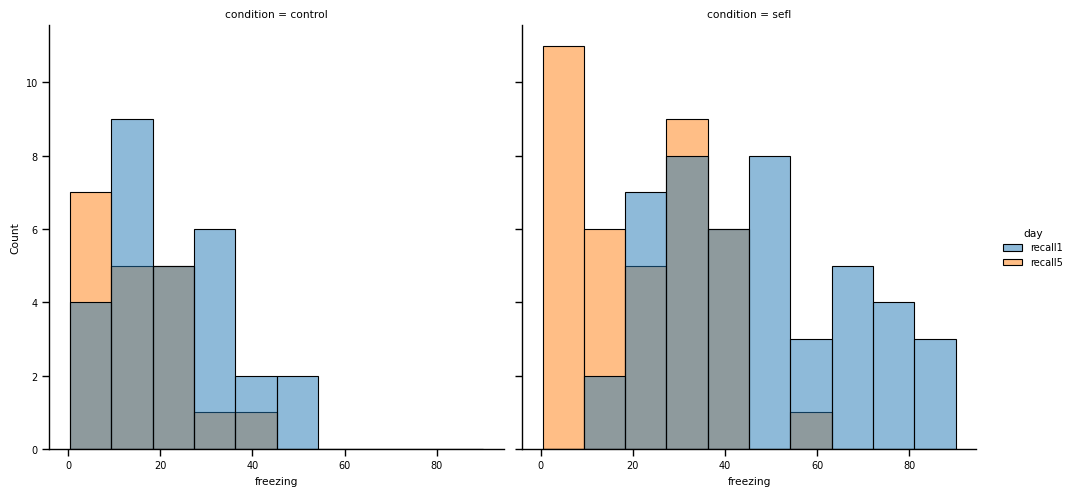

In [ ]:
# freezing on recall1 recall5
crit_list = ['recall1', 'recall5']
fila_df = filtered_freezing[filtered_freezing['day'].isin(crit_list)]
fila_df.head()
g = sns.lineplot(data=fila_df, x='day', y='freezing', hue='condition')
g2 = sns.lineplot(data=fila_df, x='day', y='freezing', hue='condition',
                 units='cohort_id', estimator=None, style='condition', alpha=.2)
g3 = sns.displot(fila_df, col="condition", x="freezing", hue="day") #TODO:fix the color order!

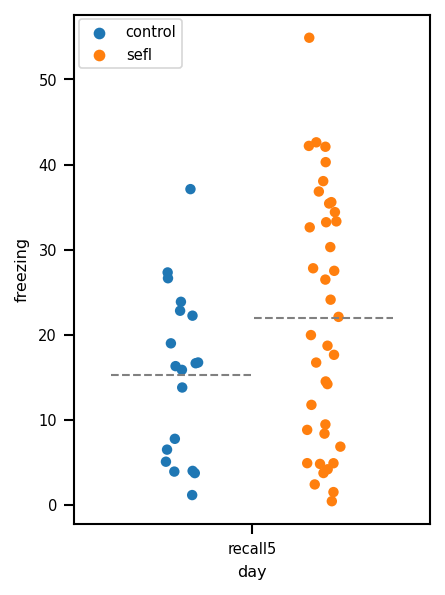

In [ ]:
# freezing on recall1 recall5
f, ax = plt.subplots(figsize=(3,4), dpi=150)
recall5_df = filtered_freezing[filtered_freezing['day'] == "recall5"]
g = sns.stripplot(data=recall5_df, x='day', y='freezing', hue='condition',
                  dodge=True)
# adding pop means
sns.boxplot(hue='condition',showmeans=True,x='day', y='freezing',
            meanline=True,
            meanprops={'color': 'grey', 'ls': '--', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            data=recall5_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=g)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], borderaxespad=.3)
plt.tight_layout()
# plt.savefig(os.path.join(save_path, "recall5_freezing_stripplot.png"),
#           transparent=True, dpi=300)

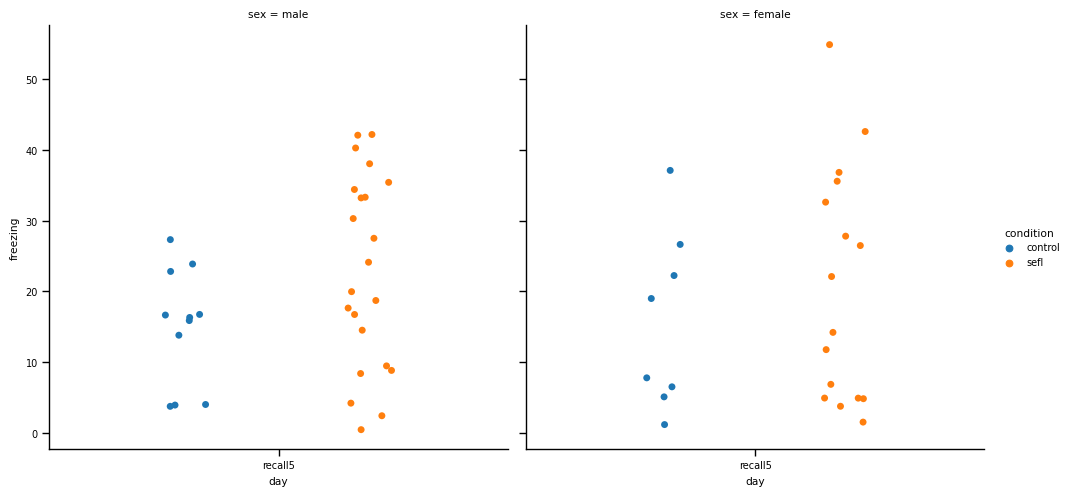

In [ ]:
# f, ax = plt.subplots(figsize=(3,4), dpi=300)
recall5_df = filtered_freezing[filtered_freezing['day'] == "recall5"]
g = sns.catplot(data=recall5_df, x='day', y='freezing', hue='condition',col='sex',
                  dodge=True)

unmelting the damn thing

In [ ]:
filtered_freezing.head(1)

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,cohort_id,date_time,man_date_time,dob
72,5.03,wt,81,sefla,control,male,ptsd2,60,60,2021-04-28,11:59 AM,n,ptsd2_81,4/28/2021 11:59 AM,2021-04-28 11:59:00,2021-02-16


In [ ]:
# new_inx = ['day']
wide_df = filtered_freezing.pivot(index=['cohort_id', 'sex',
                                         'condition', 'dob',
                                         'els'],columns='day',
                                  values=['freezing', 'date'])
wide_df.head()

freezing                     \
day                                           recall1    recall2 recall3   
cohort_id  sex    condition dob        els                                 
els1_921-2 female control   2021-10-25 n        37.32      24.93   12.24   
els1_921-3 female control   2021-10-25 n    43.700001  22.620001    15.0   
els1_921-4 female control   2021-10-25 n    72.629997      21.82   18.85   
els1_927-1 male   control   2021-10-21 n    49.240002       38.0   43.07   
els1_927-2 male   control   2021-10-21 n        38.68  33.419998   28.16   

                                                                       \
day                                        recall4 recall5      sefla   
cohort_id  sex    condition dob        els                              
els1_921-2 female control   2021-10-25 n      9.55   15.67       3.93   
els1_921-3 female control   2021-10-25 n      7.24   15.31      12.49   
els1_921-4 female control   2021-10-25 n      8.49   19.09  17.459999   
els1_927-1 male   control   2021-10-21 n     24.07   12.86  34.200001   
els1_927-2 male   control   2021-10-21 n     16.23    14.9  34.790001   

                                                            date             \
day                                             seflb    recall1    recall2   
cohort_id  sex    condition dob        els                                    
els1_921-2 female control   2021-10-25 n         11.7 2022-02-21 2022-02-25   
els1_921-3 female control   2021-10-25 n         9.22 2022-02-21 2022-02-25   
els1_921-4 female control   2021-10-25 n         6.26 2022-02-21 2022-02-25   
els1_927-1 male   control   2021-10-21 n    16.540001 2022-02-19 2022-02-24   
els1_927-2 male   control   2021-10-21 n        13.91 2022-02-19 2022-02-24   

                                                                             \
day                                           recall3    recall4    recall5   
cohort_id  sex    condition dob        els                                    
els1_921-2 female control   2021-10-25 n   2022-03-04 2022-03-10 2022-03-18   
els1_921-3 female control   2021-10-25 n   2022-03-04 2022-03-10 2022-03-18   
els1_921-4 female control   2021-10-25 n   2022-03-04 2022-03-10 2022-03-18   
els1_927-1 male   control   2021-10-21 n   2022-03-04 2022-03-10 2022-03-18   
els1_927-2 male   control   2021-10-21 n   2022-03-04 2022-03-10 2022-03-18   

                                                                  
day                                             sefla      seflb  
cohort_id  sex    condition dob        els                        
els1_921-2 female control   2021-10-25 n   2022-02-19 2022-02-20  
els1_921-3 female control   2021-10-25 n   2022-02-19 2022-02-20  
els1_921-4 female control   2021-10-25 n   2022-02-19 2022-02-20  
els1_927-1 male   control   2021-10-21 n   2022-02-17 2022-02-18  
els1_927-2 male   control   2021-10-21 n   2022-02-17 2022-02-18

In [ ]:
new_df = wide_df.reset_index()
new_df

cohort_id     sex condition        dob els   freezing             \
day                                                 recall1    recall2   
0    els1_921-2  female   control 2021-10-25   n      37.32      24.93   
1    els1_921-3  female   control 2021-10-25   n  43.700001  22.620001   
2    els1_921-4  female   control 2021-10-25   n  72.629997      21.82   
3    els1_927-1    male   control 2021-10-21   n  49.240002       38.0   
4    els1_927-2    male   control 2021-10-21   n      38.68  33.419998   
..          ...     ...       ...        ...  ..        ...        ...   
81   ptsd9_30-2    male   control 2021-10-13   n      31.02      28.85   
82   ptsd9_30-5    male   control 2021-10-13   n  33.759998       30.1   
83   ptsd9_31-1    male      sefl 2021-10-13   n  52.610001  53.209999   
84   ptsd9_31-2    male      sefl 2021-10-13   n      66.75  64.629997   
85   ptsd9_31-5    male   control 2021-10-13   n      17.57       9.44   

                                                              date             \
day    recall3    recall4 recall5      sefla      seflb    recall1    recall2   
0        12.24       9.55   15.67       3.93       11.7 2022-02-21 2022-02-25   
1         15.0       7.24   15.31      12.49       9.22 2022-02-21 2022-02-25   
2        18.85       8.49   19.09  17.459999       6.26 2022-02-21 2022-02-25   
3        43.07      24.07   12.86  34.200001  16.540001 2022-02-19 2022-02-24   
4        28.16      16.23    14.9  34.790001      13.91 2022-02-19 2022-02-24   
..         ...        ...     ...        ...        ...        ...        ...   
81   26.790001      21.02     NaN  43.540001       5.25 2022-01-14 2022-01-21   
82   26.790001  19.379999     NaN      10.19       3.62 2022-01-14 2022-01-21   
83       31.25  53.200001     NaN  64.379997  26.799999 2022-01-14 2022-01-21   
84   48.209999  28.450001     NaN  67.160004      26.73 2022-01-14 2022-01-21   
85       28.57      14.52     NaN       2.64        5.4 2022-01-14 2022-01-21   

                                                            
day    recall3    recall4    recall5      sefla      seflb  
0   2022-03-04 2022-03-10 2022-03-18 2022-02-19 2022-02-20  
1   2022-03-04 2022-03-10 2022-03-18 2022-02-19 2022-02-20  
2   2022-03-04 2022-03-10 2022-03-18 2022-02-19 2022-02-20  
3   2022-03-04 2022-03-10 2022-03-18 2022-02-17 2022-02-18  
4   2022-03-04 2022-03-10 2022-03-18 2022-02-17 2022-02-18  
..         ...        ...        ...        ...        ...  
81  2022-01-28 2022-02-11        NaT 2022-01-12 2022-01-13  
82  2022-01-28 2022-02-11        NaT 2022-01-12 2022-01-13  
83  2022-01-28 2022-02-11        NaT 2022-01-12 2022-01-13  
84  2022-01-28 2022-02-11        NaT 2022-01-12 2022-01-13  
85  2022-01-28 2022-02-11        NaT 2022-01-12 2022-01-13  

[86 rows x 19 columns]

In [ ]:
new_df[('date','sefla')]

0    2022-02-19
1    2022-02-19
2    2022-02-19
3    2022-02-17
4    2022-02-17
        ...    
81   2022-01-12
82   2022-01-12
83   2022-01-12
84   2022-01-12
85   2022-01-12
Name: (date, sefla), Length: 86, dtype: datetime64[ns]

In [ ]:
new_df['age_at_SEFLA'] = (new_df[('date','sefla')] - new_df['dob']).dt.days/7

In [ ]:
new_df.reset_index(inplace=True)
new_df.columns

MultiIndex([(     'level_0',        ''),
            (       'index',        ''),
            (   'cohort_id',        ''),
            (         'sex',        ''),
            (   'condition',        ''),
            (         'dob',        ''),
            (         'els',        ''),
            (    'freezing', 'recall1'),
            (    'freezing', 'recall2'),
            (    'freezing', 'recall3'),
            (    'freezing', 'recall4'),
            (    'freezing', 'recall5'),
            (    'freezing',   'sefla'),
            (    'freezing',   'seflb'),
            (        'date', 'recall1'),
            (        'date', 'recall2'),
            (        'date', 'recall3'),
            (        'date', 'recall4'),
            (        'date', 'recall5'),
            (        'date',   'sefla'),
            (        'date',   'seflb'),
            ('age_at_SEFLA',        '')],
           names=[None, 'day'])

In [ ]:
melt = pd.melt(new_df, id_vars=[('cohort_id'), ('sex'), ('condition'),
                                ('age_at_SEFLA')],
               value_vars=[(    'freezing', 'recall1'),
            (    'freezing', 'recall2'),
            (    'freezing', 'recall3'),
            (    'freezing', 'recall4'),
            (    'freezing', 'recall5'),
            (    'freezing',   'sefla'),
            (    'freezing',   'seflb')])
melt

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


KeyError: ignored

In [ ]:
# pd.to_numeric(new_df[('freezing', 'sefla')])
# new_df[('age_at_SEFLA')]
new_df[new_df[('condition')]=='sefl']

level_0 index   cohort_id     sex condition        dob els   freezing  \
day                                                               recall1   
6         6     6  els1_936-1  female      sefl 2021-10-26   n  81.019997   
7         7     7  els1_936-2  female      sefl 2021-10-26   n  62.599998   
8         8     8  els1_939-1    male      sefl 2021-10-25   n  65.860001   
9         9     9  els1_939-2    male      sefl 2021-10-26   n  76.669998   
10       10    10  els1_941-1    male      sefl 2021-10-25   n  58.849998   
11       11    11  els1_941-2    male      sefl 2021-10-25   n      73.18   
14       14    14    ptsd2_83    male      sefl 2021-02-16   n  38.529999   
15       15    15    ptsd2_84    male      sefl 2021-02-16   n  25.389999   
16       16    16    ptsd2_85    male      sefl 2021-02-16   n  31.889999   
19       19    19    ptsd2_93    male      sefl 2021-02-16   n  24.049999   
20       20    20    ptsd2_94    male      sefl 2021-02-16   n      38.23   
21       21    21    ptsd2_95    male      sefl 2021-02-16   n  49.509998   
22       22    22     ptsd3_1    male      sefl 2021-01-15   n      55.02   
23       23    23    ptsd3_10    male      sefl 2021-02-22   n  54.049999   
24       24    24    ptsd3_11    male      sefl 2021-01-03   n  79.050003   
25       25    25    ptsd3_12    male      sefl 2021-01-03   n  36.049999   
27       27    27     ptsd3_3    male      sefl 2021-01-15   n  31.639999   
29       29    29     ptsd3_5    male      sefl 2021-02-14   n  81.370003   
31       31    31     ptsd3_7    male      sefl 2021-03-05   n  42.549999   
33       33    33     ptsd3_9    male      sefl 2021-02-22   n  69.360001   
35       35    35    ptsd4_62    male      sefl 2021-03-17   n      35.84   
36       36    36    ptsd4_63    male      sefl 2021-03-17   n       9.81   
37       37    37    ptsd4_64    male      sefl 2021-03-17   n  78.360001   
39       39    39    ptsd4_72    male      sefl 2021-03-17   n      20.43   
40       40    40    ptsd4_73    male      sefl 2021-03-17   n  36.439999   
41       41    41    ptsd4_74    male      sefl 2021-03-17   n      31.66   
44       44    44    ptsd4_83    male      sefl 2021-03-17   n  29.129999   
45       45    45    ptsd4_84    male      sefl 2021-03-17   n  21.469999   
47       47    47    ptsd5_12  female      sefl 2021-01-15   n  90.019997   
48       48    48    ptsd5_13  female      sefl 2021-01-15   n  81.919998   
49       49    49     ptsd5_2  female      sefl 2021-03-05   n  64.879997   
50       50    50     ptsd5_3  female      sefl 2021-03-05   n  50.709999   
51       51    51     ptsd5_4  female      sefl 2021-03-05   n      52.23   
54       54    54    ptsd5_62  female      sefl 2021-01-13   n  39.299999   
55       55    55    ptsd5_64  female      sefl 2021-01-13   n  54.279999   
57       57    57    ptsd5_84  female      sefl 2021-04-09   n  74.860001   
59       59    59    ptsd6_52  female      sefl 2021-04-27   n      27.02   
62       62    62    ptsd6_63  female      sefl 2021-04-27   n       26.6   
63       63    63    ptsd6_64  female      sefl 2021-04-27   n  47.009998   
64       64    64    ptsd6_65  female      sefl 2021-04-27   n  49.650002   
66       66    66    ptsd6_72  female      sefl 2021-04-27   n      17.27   
67       67    67    ptsd6_73  female      sefl 2021-04-27   n  68.150002   
68       68    68    ptsd6_74  female      sefl 2021-04-27   n  29.360001   
69       69    69    ptsd6_75  female      sefl 2021-04-27   n  41.830002   
71       71    71  ptsd9_28-2    male      sefl 2021-10-13   n  50.209999   
72       72    72  ptsd9_28-3    male      sefl 2021-10-13   n      78.25   
75       75    75  ptsd9_29-1    male      sefl 2021-10-13   n  58.220001   
76       76    76  ptsd9_29-2    male      sefl 2021-10-13   n  19.530001   
79       79    79  ptsd9_29-5    male      sefl 2021-10-13   n      70.82   
80       80    80  ptsd9_30-1    male      sefl 2021-10-13   n  32.560001   


/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


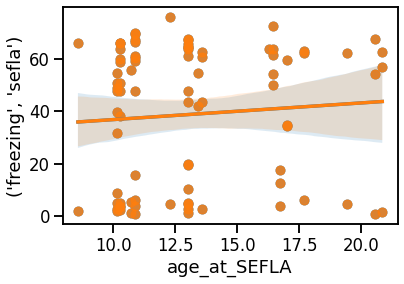

In [ ]:
g1 = sns.regplot(data=new_df[new_df[('condition',)]=='control'], y=pd.to_numeric(new_df[('freezing', 'sefla')]),
            x=new_df[('age_at_SEFLA')])
g2 = sns.regplot(data=new_df[new_df[('condition')]=='sefl'], y=pd.to_numeric(new_df[('freezing', 'sefla')]),
            x=new_df[('age_at_SEFLA')])

In [ ]:
age_corr = new_df[[(    'freezing',   'sefla'), ('age_at_SEFLA',        '')]]

In [ ]:
age_corr.columns
# age_vs_freez

MultiIndex([(    'freezing', 'sefla'),
            ('age_at_SEFLA',      '')],
           names=[None, 'day'])

In [ ]:
corr = wide_df.groupby('condition').corr()
corr

day                 recall1   recall2   recall3   recall4   recall5     sefla  \
condition day                                                                   
control   recall1  1.000000  0.513392  0.402163  0.268631  0.313811  0.359021   
          recall2  0.513392  1.000000  0.460777  0.484417  0.134246  0.527419   
          recall3  0.402163  0.460777  1.000000  0.692383  0.485150  0.414924   
          recall4  0.268631  0.484417  0.692383  1.000000  0.578586  0.439175   
          recall5  0.313811  0.134246  0.485150  0.578586  1.000000 -0.165688   
          sefla    0.359021  0.527419  0.414924  0.439175 -0.165688  1.000000   
          seflb    0.547265  0.560821  0.235168  0.261779 -0.034210  0.475999   
sefl      recall1  1.000000  0.625587  0.351033  0.477605  0.225112  0.169417   
          recall2  0.625587  1.000000  0.652376  0.423015  0.360193  0.277450   
          recall3  0.351033  0.652376  1.000000  0.488068  0.547941  0.355221   
          recall4  0.477605  0.423015  0.488068  1.000000  0.457156  0.319081   
          recall5  0.225112  0.360193  0.547941  0.457156  1.000000  0.083372   
          sefla    0.169417  0.277450  0.355221  0.319081  0.083372  1.000000   
          seflb    0.596545  0.482658  0.377984  0.309069  0.079544  0.382053   

day                   seflb  
condition day                
control   recall1  0.547265  
          recall2  0.560821  
          recall3  0.235168  
          recall4  0.261779  
          recall5 -0.034210  
          sefla    0.475999  
          seflb    1.000000  
sefl      recall1  0.596545  
          recall2  0.482658  
          recall3  0.377984  
          recall4  0.309069  
          recall5  0.079544  
          sefla    0.382053  
          seflb    1.000000

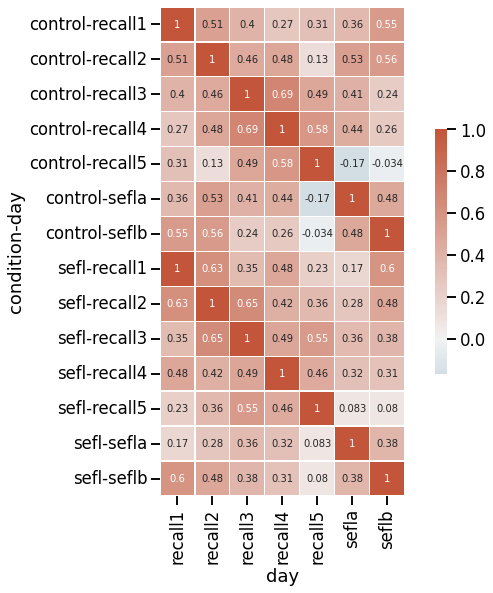

In [ ]:
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5,
            annot=True, cbar_kws={"shrink": .5})
# f.savefig(join(save_dir, "freezing_corr_map_SEFL_ctrl_.png"),
#           transparent=True, dpi=300)

In [ ]:
filtered_freezing

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,cohort_id,date_time,man_date_time,dob
72,5.030000,wt,81,sefla,control,male,ptsd2,60,60,2021-04-28,11:59 AM,n,ptsd2_81,4/28/2021 11:59 AM,2021-04-28 11:59:00,2021-02-16
73,0.450000,wt,81,seflb,control,male,ptsd2,3.5,3.5,2021-04-29,4:40 PM,n,ptsd2_81,4/29/2021 4:40 PM,2021-04-29 16:40:00,2021-02-16
74,8.280000,wt,81,recall1,control,male,ptsd2,5,5,2021-04-30,1:37 PM,n,ptsd2_81,4/30/2021 1:37 PM,2021-04-30 13:37:00,2021-02-16
75,7.120000,wt,81,recall2,control,male,ptsd2,5,5,2021-05-03,10:17 AM,n,ptsd2_81,5/3/2021 10:17 AM,2021-05-03 10:17:00,2021-02-16
76,7.570000,wt,81,recall3,control,male,ptsd2,5,5,2021-05-05,10:04 AM,n,ptsd2_81,5/5/2021 10:04 AM,2021-05-05 10:04:00,2021-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,72.629997,wt,921-4,recall1,control,female,els1,,,2022-02-21,,n,els1_921-4,2/21/22,2022-02-21 00:00:00,2021-10-25
1160,21.820000,wt,921-4,recall2,control,female,els1,,,2022-02-25,,n,els1_921-4,2/25/22,2022-02-25 00:00:00,2021-10-25
1161,18.850000,wt,921-4,recall3,control,female,els1,,,2022-03-04,,n,els1_921-4,3/4/22,2022-03-04 00:00:00,2021-10-25
1162,8.490000,wt,921-4,recall4,control,female,els1,,,2022-03-10,,n,els1_921-4,3/10/22,2022-03-10 00:00:00,2021-10-25


In [ ]:
sns.catplot(data=filtered_freezing, x=)

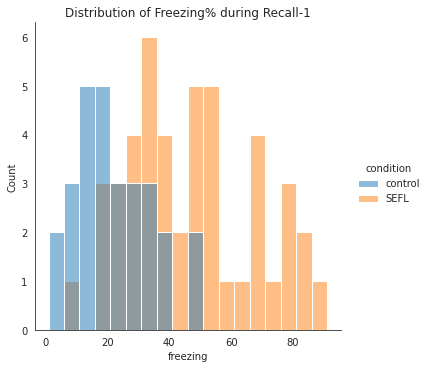

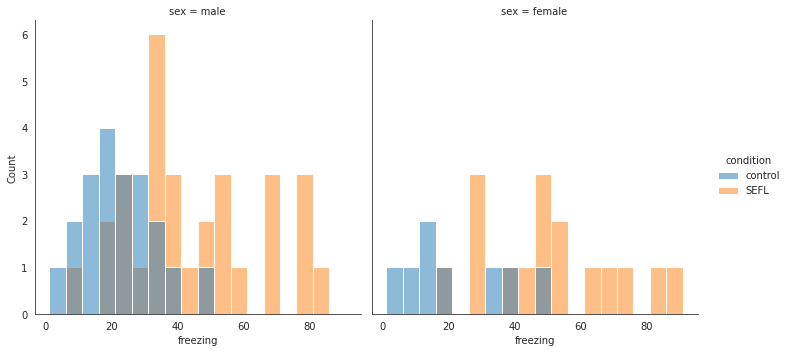

In [ ]:
df = filtered_freezing[filtered_freezing["day"] == "recall1"]
g = sns.displot(df, x="freezing", hue="condition",
                hue_order=["control", "SEFL"], binwidth=5)
g.set(title='Distribution of Freezing% during Recall-1')

g2 = sns.displot(df, x="freezing", col="sex", hue="condition",
                 hue_order=["control", "SEFL"],binwidth=5)
# g.savefig(os.path.join(save_path, 'SEFL_reacall1_frezing_distrib_slected_cohorts.png'),
#           transparent=True, dpi=300)
# g2.savefig(os.path.join(save_path, 'SEFL_reacall1_frezing_distrib_slected_cohorts_males_females.png'),
#            transparent=True, dpi=300)

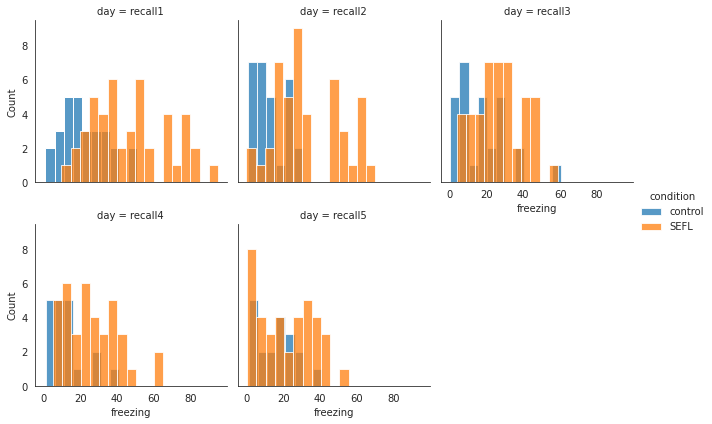

In [ ]:
g = sns.FacetGrid(anova_df, col="day", hue="condition", col_wrap=3,
                sharey=True, sharex=True, legend_out=True)

g.map(sns.histplot, "freezing", common_bins=True, binwidth=5,
      hue_order=["control", "SEFL"], palette="deep")
g.add_legend()
# g.savefig(os.path.join(save_path, 'SEFL_recall1to5_conditions_frezing_distrib_selected_cohorts.png'),
#           transparent=True, dpi=300)

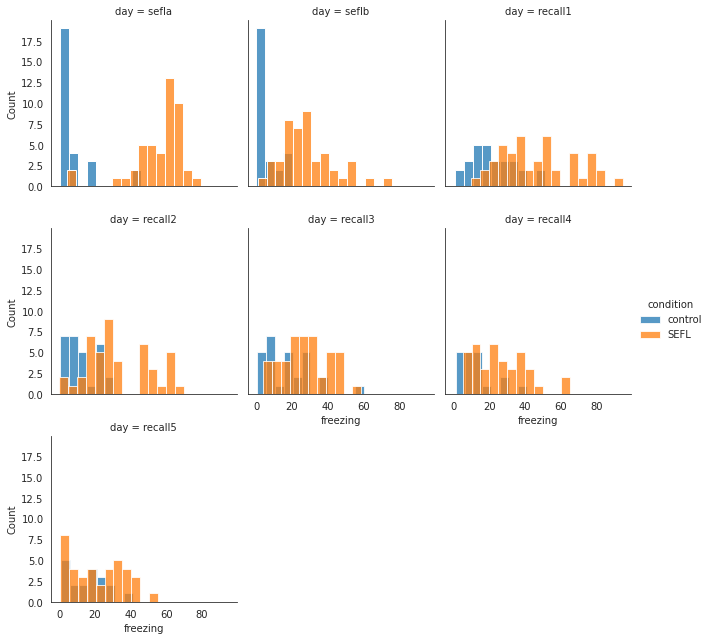

In [ ]:
g = sns.FacetGrid(filtered_freezing, col="day", hue="condition", col_wrap=3,
                sharey=True, sharex=True, legend_out=True)

g.map(sns.histplot, "freezing", common_bins=True, binwidth=5,
      hue_order=["control", "SEFL"], palette="deep")
g.add_legend()

# g.savefig(os.path.join(save_path, 'SEFL_all_conditions_frezing_distrib_selected_cohorts.png'),
#           transparent=True, dpi=300)

In [ ]:
sefl_df = filtered_freezing[filtered_freezing['condition']== 'sefl']

high_freezers = filtered_freezing[(filtered_freezing['day']=='recall1') &
                                  (filtered_freezing['condition']== 'sefl') &
                                  (filtered_freezing['freezing']> 60)]
low_freezers = filtered_freezing[(filtered_freezing['day']=='recall1') &
                                 (filtered_freezing['condition']== 'sefl') &
                                  (filtered_freezing['freezing']< 30)]
avg_freezers =filtered_freezing[(filtered_freezing['day']=='recall1') &
                                 (filtered_freezing['condition']== 'sefl') &
                                  (filtered_freezing['freezing']> 30) &
                                  (filtered_freezing['freezing']< 60)]

keys_hi = list(high_freezers['cohort_id'].values)
keys_low = list(low_freezers['cohort_id'].values)
keys_avg = list(avg_freezers['cohort_id'].values)

hf_df = filtered_freezing[filtered_freezing['cohort_id'].isin(keys_hi)]
lf_df = filtered_freezing[filtered_freezing['cohort_id'].isin(keys_low)]
avg_df = filtered_freezing[filtered_freezing['cohort_id'].isin(keys_avg)]
print(hf_df['cohort_id'].unique())
print(lf_df['cohort_id'].unique())

['ptsd3_5' 'ptsd3_9' 'ptsd3_11' 'ptsd4_64' 'ptsd5_2' 'ptsd5_84' 'ptsd5_12'
 'ptsd5_13' 'ptsd6_73' 'ptsd9_28-3' 'ptsd9_29-5' 'ptsd9_31-2' 'els1_939-1'
 'els1_939-2' 'els1_941-2' 'els1_936-1' 'els1_936-2']
['ptsd2_84' 'ptsd2_93' 'ptsd4_63' 'ptsd4_72' 'ptsd4_83' 'ptsd4_84'
 'ptsd6_52' 'ptsd6_63' 'ptsd6_74' 'ptsd6_72' 'ptsd9_29-2']


Text(0.5, 0, 'sessions')

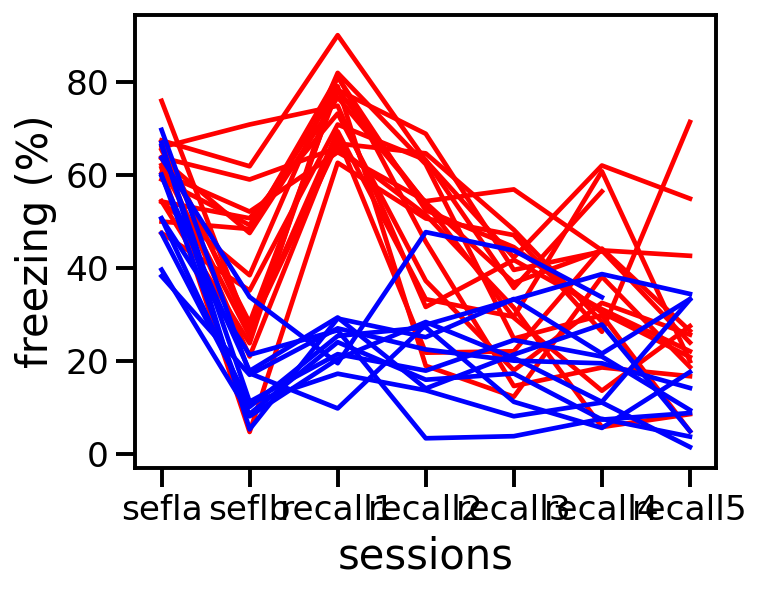

In [ ]:
f, ax = plt.subplots(figsize=(5,4), dpi=150) # , dpi=300
# g = sns.lineplot(data=filtered_freezing[filtered_freezing['condition']== 'SEFL'],
#                  x='day', y='freezing', ax=ax
#                  )
g = sns.lineplot(data=hf_df, x='day', y='freezing', units='cohort_id',
                 estimator=None, ax=ax, color='red')
g = sns.lineplot(data=lf_df, x='day', y='freezing', units='cohort_id',
                 estimator=None, ax=ax, color='blue')

ax.set_ylabel('freezing (%)',fontsize=20)
ax.set_xlabel('sessions', fontsize=20)

# plt.savefig(join(save_dir, 'high_and_low_freezers_SEFL_group.png'),
#           transparent=True)

# g = sns.lineplot(data=avg_df, x='day', y='freezing', units='cohort_id',
#                  estimator=None)

In [ ]:
sefl_learning = merged_df[merged_df['day']=='recall5']
sefl_learning.head()
# sns.scatterplot(data=sefl_learning, x='freezing', y='slope_pre_shock06', hue='condition')

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,cohort_id,date_time,man_date_time,dob
6,43.330002,2aFlox_het,5HT2Afl05a-5,recall5,control,male,ptsd1,5,5,NaT,NaN,ptsd1_5HT2Afl05a-5,NaN,NaT,2020-12-11
15,47.320000,wt,5HT2Afl05a-7,recall5,control,male,ptsd1,5,5,NaT,NaN,ptsd1_5HT2Afl05a-7,NaN,NaT,2020-12-11
24,3.210000,wt,5HT2ACre01a-3,recall5,control,male,ptsd1,5,5,NaT,NaN,ptsd1_5HT2ACre01a-3,NaN,NaT,2020-12-31
33,7.850000,wt,sert26a-3,recall5,control,male,ptsd1,5,5,NaT,NaN,ptsd1_sert26a-3,NaN,NaT,2020-11-30
42,47.840000,wt,5HT2Afl5a-6,recall5,SEFL,male,ptsd1,5,5,NaT,NaN,ptsd1_5HT2Afl5a-6,NaN,NaT,2020-12-11


**todo:** construct a df where columns are mouseID, sex, freezing during recall1, recall2 etc. , condition. then you can use the `pairgrid` function below

### Analyzing cohorts with OFT

In [ ]:
# filtering out the cohorts for this analysis (OFT)
cohort_list = ['ptsd2', 'ptsd4', 'ptsd6']
filtered_freezing = freezing[freezing['cohort'].isin(cohort_list)]
filtered_freezing
# setting unique id-s for everyone which is also aligned with id-s of OFT
filtered_freezing.drop(['cohort_id'], axis='columns')
filtered_freezing['cohort'] = filtered_freezing['cohort'].str.upper()
filtered_freezing['cohort_id']= filtered_freezing['cohort']+'_'+filtered_freezing['id']
# filtered_freezing.head()

# saing the filtered csv
# filtered_freezing.to_csv(save_path+'fitered.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
filtered_freezing

,freezing,cohort_id,id,day,condition,sex,cohort,reexposure_mins,duration,days_since_sefla
72,5.026333,PTSD2_81,81,sefla,control,male,PTSD2,NaN,60.0,0.0
73,8.831167,PTSD2_82,82,sefla,control,male,PTSD2,NaN,60.0,0.0
74,2.603000,PTSD2_91,91,sefla,control,male,PTSD2,NaN,60.0,0.0
75,1.912500,PTSD2_92,92,sefla,control,male,PTSD2,NaN,60.0,0.0
76,50.638833,PTSD2_84,84,sefla,SEFL,male,PTSD2,NaN,60.0,0.0
...,...,...,...,...,...,...,...,...,...,...
517,3.870681,PTSD6_71,71,recall6,control,female,PTSD6,25.0,30.0,55.0
518,4.938455,PTSD6_75,75,recall6,SEFL,female,PTSD6,25.0,30.0,55.0
519,16.580157,PTSD6_74,74,recall6,SEFL,female,PTSD6,25.0,30.0,55.0
520,37.787335,PTSD6_73,73,recall6,SEFL,female,PTSD6,25.0,30.0,55.0


In [ ]:
# number of mice in this data:
mice_number = filtered_freezing.cohort_id.nunique()
print(f'all mice: {mice_number}')
males_females = filtered_freezing.groupby(['sex']).cohort_id.nunique()
print(f'males and females: {males_females}')

all mice: 34
males and females: sex
female    12
male      22
Name: cohort_id, dtype: int64


### plotting freezing distributions

### ploting freezing over time for all mice in the dataframe

### only for the 3 PTSD groups (2,4,6)

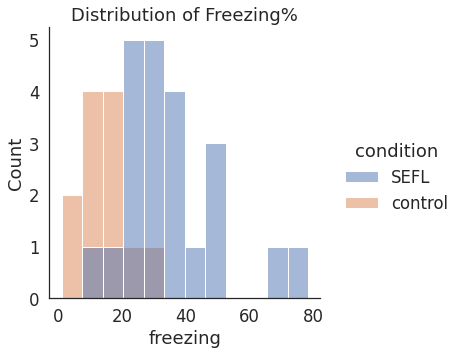

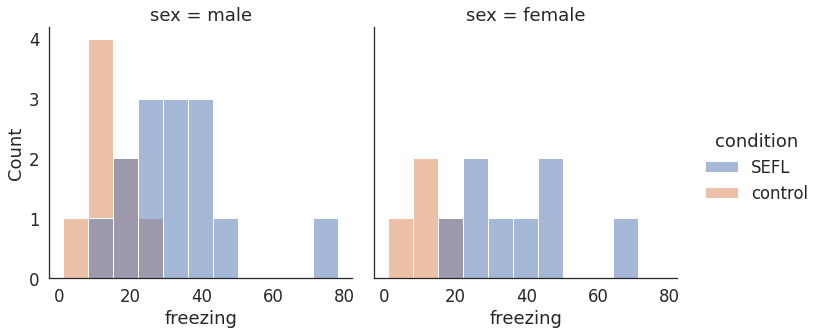

In [ ]:
df = filtered_freezing[filtered_freezing["day"] == "recall1"]
# control = df[df["condition"] == "control"]
# sefl = df[df["condition"] == "SEFL"]
d = sns.displot(df, x="freezing", hue="condition", bins=12)
d.set(title='Distribution of Freezing%')
d2 = sns.displot(df, x="freezing", col="sex", hue="condition", bins=11)

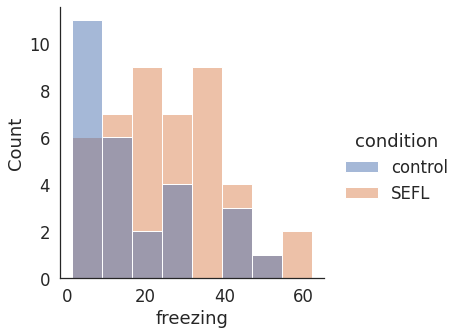

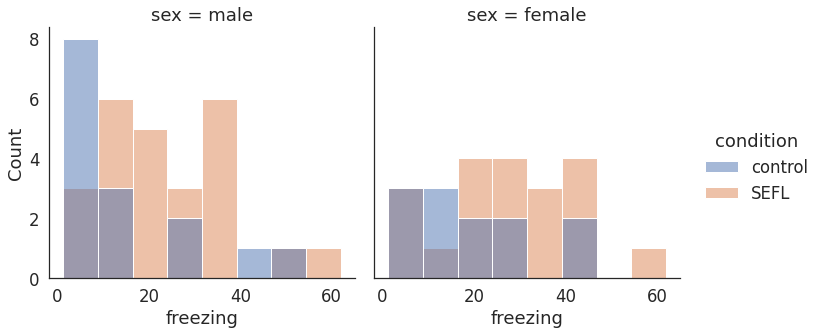

In [ ]:
df = freezing[freezing["day"] == "recall4"]
sns.displot(df, x="freezing", hue="condition")
sns.displot(df, x="freezing", col="sex", hue="condition")

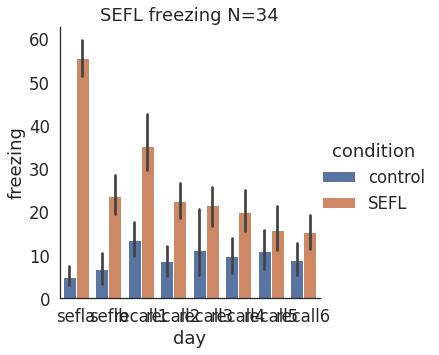

In [ ]:
g = sns.catplot(data = filtered_freezing, kind='bar',
               x="day", y="freezing", hue="condition")

g.set(title = f'SEFL freezing N={mice_number}')

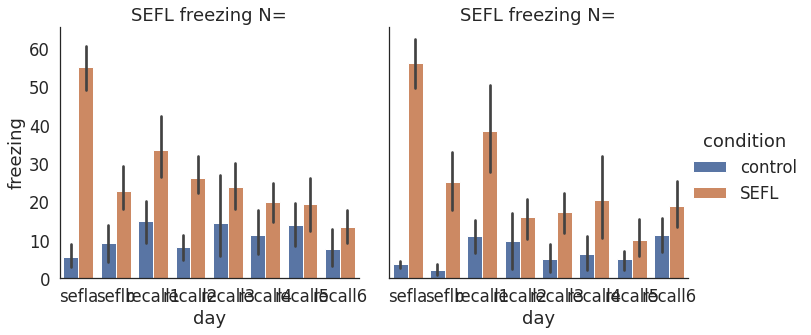

In [ ]:
g2 = sns.catplot(data= filtered_freezing, kind='bar',
                x='day', y='freezing', hue='condition',
                 col='sex')
g2.set(title = 'SEFL freezing N=')

In [ ]:
#saving the plots
g.savefig(save_path+'ptsd_freezing_all.png')
g2.savefig(save_path+'ptsd_freezing_sexes.png')

### T-tests on all the mice

In [ ]:
days = filtered_freezing.day.unique()
days

array(['sefla', 'seflb', 'recall1', 'recall2', 'recall3', 'recall4',
       'recall5', 'recall6'], dtype=object)

In [ ]:
# t-tests on the whole population
stats = []
for day in days:
  df = filtered_freezing[filtered_freezing["day"] == day]
  ctrl = df[df["condition"] == "control"]
  sefl = df[df["condition"] == "SEFL"]
  stats.append((day, ttest_ind(ctrl['freezing'], sefl['freezing'])))
stats

NameError: ignored

### T-test on males and females

In [ ]:
male_stats = []
male_df = filtered_freezing[filtered_freezing['sex'] == "male"]
for day in days:
  df = male_df[male_df["day"] == day]
  ctrl = df[df["condition"] == "control"]
  sefl = df[df["condition"] == "SEFL"]
  male_stats.append((day, ttest_ind(ctrl['freezing'], sefl['freezing'])))
male_stats

[('sefla',
  Ttest_indResult(statistic=-11.527460600337495, pvalue=2.7557735861618507e-10)),
 ('seflb',
  Ttest_indResult(statistic=-3.078262484176159, pvalue=0.005929877509473304)),
 ('recall1',
  Ttest_indResult(statistic=-3.037196418521732, pvalue=0.0065067898982747565)),
 ('recall2',
  Ttest_indResult(statistic=-5.028456062798688, pvalue=6.438081146607302e-05)),
 ('recall3',
  Ttest_indResult(statistic=-1.4634211477156827, pvalue=0.15889212152850243)),
 ('recall4',
  Ttest_indResult(statistic=-1.9625338690468423, pvalue=0.06376337577659434)),
 ('recall5',
  Ttest_indResult(statistic=-0.9761344255878741, pvalue=0.3406578397974326)),
 ('recall6',
  Ttest_indResult(statistic=-1.538357059662128, pvalue=0.13963311149357552))]

In [ ]:
female_stats = []
female_df = filtered_freezing[filtered_freezing['sex'] == "female"]
for day in days:
  df = female_df[female_df["day"] == day]
  ctrl = df[df["condition"] == "control"]
  sefl = df[df["condition"] == "SEFL"]
  female_stats.append((day, ttest_ind(ctrl['freezing'], sefl['freezing'])))
female_stats

[('sefla',
  Ttest_indResult(statistic=-10.279515432596304, pvalue=1.233929879125089e-06)),
 ('seflb',
  Ttest_indResult(statistic=-3.895658699859487, pvalue=0.002981981934503957)),
 ('recall1',
  Ttest_indResult(statistic=-3.1783138217718028, pvalue=0.009847606843517865)),
 ('recall2',
  Ttest_indResult(statistic=-1.218048860401253, pvalue=0.25116381937537935)),
 ('recall3',
  Ttest_indResult(statistic=-2.848390929909765, pvalue=0.017297741675859686)),
 ('recall4',
  Ttest_indResult(statistic=-1.6590817563920923, pvalue=0.12808870979678286)),
 ('recall5',
  Ttest_indResult(statistic=-1.2018459172524187, pvalue=0.2571115900783359)),
 ('recall6',
  Ttest_indResult(statistic=-1.445983983184109, pvalue=0.17878461225352893))]

### Reading and wranging w/ OFT data

In [ ]:
oft_path = os.path.join(base_data_path, oft_data)
oft_df = pd.read_csv(oft_path)
# oft_df.rename(columns={'timepoint': 'day'}, inplace=True)
oft_df.drop(oft_df.columns[0:2], axis=1, inplace=True)
oft_df.tail()

,cohort,behavior,timepoint,mouse_id,center_occupancy,floor_occupancy,velocity_cmps,distance_cm,condition,sex,cohort_id,timepoint_numerical
97,PTSD6,OFT,4wk,71,0.132302,0.862122,5.474031,3019.556578,control,female,PTSD6_71,4
98,PTSD6,OFT,4wk,72,0.089647,0.799808,5.415922,3579.920656,SEFL,female,PTSD6_72,4
99,PTSD6,OFT,4wk,73,0.078712,0.891427,3.922008,2374.447952,SEFL,female,PTSD6_73,4
100,PTSD6,OFT,4wk,74,0.184584,0.853131,6.396093,3871.233827,SEFL,female,PTSD6_74,4
101,PTSD6,OFT,4wk,75,0.120061,0.917665,6.269212,3501.592509,SEFL,female,PTSD6_75,4


In [ ]:
print(oft_df.shape)
filtered_freezing.shape

(102, 12)


(272, 10)

merging freezing data w/ OFT

In [ ]:
frames = [filtered_freezing, oft_df]
result = pd.merge(filtered_freezing, oft_df, on=["cohort_id", "sex", "condition", "cohort"],
                  how="outer")

In [ ]:
result.shape

(816, 18)

In [ ]:
result.to_csv(save_path+'merged.csv')

In [ ]:
result

,freezing,cohort_id,id,day,condition,sex,cohort,reexposure_mins,duration,days_since_sefla,behavior,timepoint,mouse_id,center_occupancy,floor_occupancy,velocity_cmps,distance_cm,timepoint_numerical
0,5.026333,PTSD2_81,81,sefla,control,male,PTSD2,NaN,60.0,0.0,OFT,baseline,81,0.158255,0.822902,5.330484,3676.576855,0
1,5.026333,PTSD2_81,81,sefla,control,male,PTSD2,NaN,60.0,0.0,OFT,2wk,81,0.124919,0.823925,6.546537,3377.576542,2
2,5.026333,PTSD2_81,81,sefla,control,male,PTSD2,NaN,60.0,0.0,OFT,4wk,81,0.230417,0.858311,7.539227,4530.445303,4
3,0.445000,PTSD2_81,81,seflb,control,male,PTSD2,NaN,3.0,1.0,OFT,baseline,81,0.158255,0.822902,5.330484,3676.576855,0
4,0.445000,PTSD2_81,81,seflb,control,male,PTSD2,NaN,3.0,1.0,OFT,2wk,81,0.124919,0.823925,6.546537,3377.576542,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,6.856634,PTSD6_72,72,recall5,SEFL,female,PTSD6,20.0,5.0,48.0,OFT,baseline,72,0.096495,0.716125,6.891135,4503.929227,0
812,6.856634,PTSD6_72,72,recall5,SEFL,female,PTSD6,20.0,5.0,48.0,OFT,4wk,72,0.089647,0.799808,5.415922,3579.920656,4
813,13.806911,PTSD6_72,72,recall6,SEFL,female,PTSD6,25.0,30.0,55.0,OFT,2wk,72,0.094947,0.915691,2.909873,1988.763732,2
814,13.806911,PTSD6_72,72,recall6,SEFL,female,PTSD6,25.0,30.0,55.0,OFT,baseline,72,0.096495,0.716125,6.891135,4503.929227,0
